# "Time Series Forecasting with Statistical Models"
> "statsforecast makes forecasting with statistical models fast & easy"

- toc: true
- branch: main
- badges: true
- comments: true
- categories: [statistics, forecasting, models]
- image: images/nixtla_logo.png

## TL;DR

In this post we introduce **statsforecast**, an open-source framework that makes the implementation of statistical models in forecasting tasks fast and easy. *statsforecast* is able to handle thousands of time series and is efficient both time and memory wise. With this library you can easily create benchmarks on which to build more complex models; it can also allows you to run your own models in a parallel fashion. In this post we also offer a guide on how to use "Forecast Value Added" for Bencharmikg different models and assessing competing models.

## Introduction

In this post, we will talk about using statistical models in forecasting tasks. In particular, we introduce **statsforecast**. This Python library allows fitting statistical models in a simple and computationally efficient way for hundreds of thousands of time series so that you can benchmark your own models quickly. Throughout this post, we will show how to use the library to calculate the Forecast Value Added of some models with respect to a benchmark model. This methodology allows us to select the best model among a variety.

## Motivation

Deep learning and Machine Learning models have demonstrated state-of-the-art performance in time series forecasting tasks. However, it is helpful to have a battery of simpler models to benchmark and validate the value that those models add.

In business problems, metrics such as Forecast Value Added (FVA) are usually used to compare the value-added of more complex models against more straightforward techniques to implement and explain to decision-makers. FVA is calculated by subtracting the loss of a benchmark model from the loss of a more complex one. In the [following example](https://www.sas.com/content/dam/SAS/en_us/doc/whitepaper1/forecast-value-added-analysis-106186.pdf), three models were fitted: Naive, Statistical, and Override. The first column shows the Mean Average Percentage Error (MAPE) of these three models. The `FVA vs. Naive` column displays in the second row the difference between the Naive's MAPE and the Statistical's MAPE, which is positive; that means that the Statistical adds value to the process. Likewise, the third row shows the difference between the Naive's MAPE and the Override's MAPE; the result is negative, so the model Override doesn't add any value.

![FVA table](fva-table.png)

A wide range of statistical base models is included in *statsforecast* that can be used for decision making or as benchmarks for implementing more complete models. Also included are models for specific tasks, such as forecasting sparse (or intermittent) time-series, i.e., time series with a high percentage of zero values, such as sales. These models exist in implementations for the R programming language but not for Python.

## statsforecast

To make benchmarking easier, we created [statsforecast](https://github.com/Nixtla/statsforecast), which is a framework to help you forecast time series using statistical models. You just need to give it a model you want to use and let *statsforecast* do the rest.

### Included models

- **ADIDA**: Temporal aggregation is used for reducing the presence of zero observations, thus mitigating the undesirable effect of the variance observed in the intervals. ADIDA uses equally sized time buckets to perform non-overlapping temporal aggregation and predict the demand over a pre-specified lead-time. The time bucket is set equal to the mean inter-demand interval. SES is used to obtain the forecasts. 
- **Croston Classic**: The method proposed by Croston to forecast series that display intermittent demand. The method decomposes the original series into the non-zero demand size and the inter-demand intervals and models them using Simple Exponential Smoothing with a predefined parameter. 
- **Croston SBA**: SBA stands for Syntetos-Boylan Approximation. A variant of the Croston's method that utilizes a debiasing factor.
- **Croston Optimized**: Like Croston, but this model optimizes the Simple Exponential Smoothing for both the non-zero demand size and the inter-demand intervals.
- **Historic average**: Simple average of the time series.
- **iMAPA**: iMAPA stands for Intermittent Multiple Aggregation Prediction Algorithm. Another way for implementing temporal aggregation in demand forecasting. However, in contrast to ADIDA that considers a single aggregation level, iMAPA considers multiple ones, aiming at capturing different dynamics of the data. Thus, iMAPA proceeds by averaging the derived point forecasts, generated using SES. 
- **Naive**: Uses the last value of the time series as forecast. The simplest model for time series forecasting.
- **Random Walk with Drift**: Projects the historic trend from the last observed value.
- **Seasonal Exponential Smoothing**: Adjusts a Simple Exponential Smoothing model for each seasonal period.
- **Seasonal Naive**: Like Naive, but this time the forecasts of the model are equal to the last known observation of the same period in order for it to capture possible weekly seasonal variations.
- **Seasonal Window Average**: Uses the last window (defined by the user) to calculate an average for each seasonal period.
- **SES**: SES stands for Simple Exponential Smoothing. This model recursively weights the most recent observations in the time series. Useful for time series with no trend.
- **TSB**: TSB stands for Teunter-Syntetos-Babai. A modification to Croston's method that replaces the inter-demand intervals component with the demand probability.
- **Window Average**: Uses the last window (defined by the user) to calculate an average.

### Usage

To create an ample set of benchmarks you can install **statsforecast** which is available in [PyPI](https://pypi.org/project/statsforecast/) (`pip install statsforecast`).

### Libraries

In [1]:
#%gist gistname: libraries-statsforecast.py
import random
from itertools import product
from IPython.display import display, Markdown
from multiprocessing import cpu_count

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from nixtlats.data.datasets.m4 import M4, M4Info

from statsforecast import StatsForecast
from statsforecast.models import (
    adida, 
    croston_classic, 
    croston_sba, 
    croston_optimized,
    historic_average,
    imapa,
    naive,
    random_walk_with_drift, 
    seasonal_exponential_smoothing,
    seasonal_naive, 
    seasonal_window_average,
    ses, 
    tsb,
    window_average
)

### Data

In this example we use the M4 time series competition data. The objective of the competition was to validate models for different frequencies and seasonalities data. The dataset was [originally released publicly](https://github.com/Mcompetitions/M4-methods) and it was released with a [completely open-access license](https://github.com/Mcompetitions/M4-methods/issues/16). To download the data we used [nixtlats](https://github.com/Nixtla/nixtlats). In this example, we use Daily time series.  

In [2]:
#%gist gistname: get-data-statsforecast.py
series, _, S_df = M4.load('data', 'Daily')
group = M4Info['Daily']
horizon = group.horizon

Initially, the data don't contain the actual dates of each observation, so the following line creates a datestamp for each time series.

In [3]:
#%gist gistname: add-dates-data-statsforecast.py
series['ds'] = series.groupby('unique_id')['ds'].transform(lambda x: pd.date_range(end='2021-01-01', periods=len(x), freq='D'))

The function `M4.load` returns train + test data, so we need to separate them.

In [4]:
#%gist gistname: split-data-statsforecast.py
series_test = series.groupby('unique_id').tail(horizon).copy()
series = series.drop(series_test.index)

In [5]:
#%gist gistname: data-statsforecast.py upload: both
series['unique_id'] = series['unique_id'].astype('object')
series = series.set_index('unique_id')
series.reset_index()

,unique_id,ds,y
0,D1,2018-03-19,1017.10
1,D1,2018-03-20,1019.30
2,D1,2018-03-21,1017.00
3,D1,2018-03-22,1019.20
4,D1,2018-03-23,1018.70
...,...,...,...
9964653,D999,2020-12-14,1248.02
9964654,D999,2020-12-15,1243.37
9964655,D999,2020-12-16,1234.18
9964656,D999,2020-12-17,1248.47


In [6]:
#%gist gistname: n-ts-statsforecast.py
series.index.unique().shape

(4227,)

This is the required input format.
* an index named **unique_id** that identifies each time series. In this example, we have 4,227 time series.
* a **ds** column with the dates.
* a **y** column with the values.

### Training

We now define the statistical models we will use. We must define a list of functions. If the model has additional parameters, besides the forecast horizon, it must be included as a tuple with the model and the additional parameters.

In [7]:
#%gist gistname: models-statsforecast.py
seasonality = 7 #Daily data

models = [
    adida,
    croston_classic,
    croston_sba,
    croston_optimized,
    historic_average,
    imapa,
    naive,
    random_walk_with_drift,
    (seasonal_exponential_smoothing, seasonality, 0.2),
    (seasonal_naive, seasonality),
    (seasonal_window_average, seasonality, 2 * seasonality),
    (ses, 0.1),
    (tsb, 0.3, 0.2),
    (window_average, 2 * seasonality)
    
]

Now we define our trainer, `StatsForecast`, where we define the models we want to use, the frequency of the data and the number of cores used to parallelize the training job.

In this way adjusting these models and generating forecasts is as simple as the following lines. The main class is `StatsForecast`; it receives four parameters:

- `df`: A pandas dataframe with time series in long format.
- `models`: A list of models to fit each time series.
- `freq`: Frequency of the time series.
- `n_jobs`: Number of cores to be used in the fitting process. The default is 1 job. To compute the process in parallel you can use the `cpu_count()` function from `multiprocessing`.

In [8]:
#%gist gistname: forecast-statsforecast.py upload: both
fcst = StatsForecast(df=series, models=models, freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for adida.
INFO:statsforecast.core:Computed forecasts for croston_classic.
INFO:statsforecast.core:Computed forecasts for croston_sba.
INFO:statsforecast.core:Computed forecasts for croston_optimized.
INFO:statsforecast.core:Computed forecasts for historic_average.
INFO:statsforecast.core:Computed forecasts for imapa.
INFO:statsforecast.core:Computed forecasts for naive.
INFO:statsforecast.core:Computed forecasts for random_walk_with_drift.
INFO:statsforecast.core:Computed forecasts for seasonal_exponential_smoothing_season_length-7_alpha-0.2.
INFO:statsforecast.core:Computed forecasts for seasonal_naive_season_length-7.
INFO:statsforecast.core:Computed forecasts for seasonal_window_average_season_length-7_window_size-14.
INFO:statsforecast.core:Computed forecasts for ses_alpha-0.1.
INFO:statsforecast.core:Computed forecasts for tsb_alpha_d-0.3_alpha_p-0.2.
INFO:statsforecast.core:Computed forecasts 

CPU times: user 634 ms, sys: 314 ms, total: 948 ms
Wall time: 17.7 s


,unique_id,ds,adida,croston_classic,croston_sba,croston_optimized,historic_average,imapa,naive,random_walk_with_drift,seasonal_exponential_smoothing_season_length-7_alpha-0.2,seasonal_naive_season_length-7,seasonal_window_average_season_length-7_window_size-14,ses_alpha-0.1,tsb_alpha_d-0.3_alpha_p-0.2,window_average_window_size-14
0,D1,2020-12-19,2022.386841,2008.841919,1908.399780,2022.386841,1422.054199,2022.386841,2029.699951,2030.707520,1978.295654,2013.800049,1970.857178,2008.841919,2022.386841,2014.849731
1,D1,2020-12-20,2022.386841,2008.841919,1908.399780,2022.386841,1422.054199,2022.386841,2029.699951,2031.715088,1980.360107,2003.400024,1967.971436,2008.841919,2022.386841,2014.849731
2,D1,2020-12-21,2022.386841,2008.841919,1908.399780,2022.386841,1422.054199,2022.386841,2029.699951,2032.722656,1982.302002,2015.599976,1969.692993,2008.841919,2022.386841,2014.849731
3,D1,2020-12-22,2022.386841,2008.841919,1908.399780,2022.386841,1422.054199,2022.386841,2029.699951,2033.730225,1985.146851,2009.699951,1973.843018,2008.841919,2022.386841,2014.849731
4,D1,2020-12-23,2022.386841,2008.841919,1908.399780,2022.386841,1422.054199,2022.386841,2029.699951,2034.737793,1986.950684,2022.099976,1973.500000,2008.841919,2022.386841,2014.849731
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59173,D999,2020-12-28,1247.819702,1256.707031,1193.871582,1247.819702,1023.906494,1247.819702,1245.170044,1248.711304,1223.670044,1248.020020,1198.705078,1256.707031,1247.819702,1259.862183
59174,D999,2020-12-29,1247.819702,1256.707031,1193.871582,1247.819702,1023.906494,1247.819702,1245.170044,1249.065430,1223.863892,1243.369995,1201.191406,1256.707031,1247.819702,1259.862183
59175,D999,2020-12-30,1247.819702,1256.707031,1193.871582,1247.819702,1023.906494,1247.819702,1245.170044,1249.419556,1224.018555,1234.180054,1202.094238,1256.707031,1247.819702,1259.862183
59176,D999,2020-12-31,1247.819702,1256.707031,1193.871582,1247.819702,1023.906494,1247.819702,1245.170044,1249.773682,1227.025635,1248.469971,1203.289185,1256.707031,1247.819702,1259.862183


### Forecast Value Added

In this example, we'll use the `historic_average` model as a benchmark; this is on of the simpler model among the fitted ones (it only takes the mean value of the time series as forecast).

In [9]:
#%gist gistname: test-set-statsforecast.py
forecasts = forecasts.reset_index().merge(series_test, how='left', on=['unique_id', 'ds'])
models = forecasts.drop(columns=['unique_id', 'ds', 'y']).columns.to_list()

In [10]:
#%gist gistname: fva-statsforecast.py upload: both
from nixtlats.losses.numpy import mape

y = forecasts['y'].values
mape_bench = mape(y, forecasts['historic_average'].values)

fva = {}
for model in models:
    mape_model = mape(y, forecasts[model].values)
    fva[model] = mape_bench - mape_model
    
pd.DataFrame(fva, index=['FVA']).T.sort_values('FVA').rename_axis('model').reset_index()

,model,FVA
0,historic_average,0.000000
1,seasonal_window_average_season_length-7_window...,22.780836
2,croston_sba,24.121888
3,seasonal_exponential_smoothing_season_length-7...,24.757785
4,croston_classic,27.173895
5,ses_alpha-0.1,27.173895
6,window_average_window_size-14,27.366707
7,seasonal_naive_season_length-7,27.982440
8,adida,28.354984
9,croston_optimized,28.354984


As the table shows, the Forecast Value Added against the `historic_average` model is positive for the majority of the models.

### Visualization

In this section we present visual examples of the forecasts generated.

In [11]:
#%gist gistname: grid-viz-statsforecast.py
def plot_grid_prediction(y, y_hat, models, plot_random=True, unique_ids=None):
    """
    y: pandas df
        panel with columns unique_id, ds, y
    y_hat: pandas df
        panel with columns unique_id, ds, y_hat
    models: List[str]
        List of models to plot
    plot_random: bool
        if unique_ids will be sampled
    unique_ids: list
        unique_ids to plot
    """
    pd.plotting.register_matplotlib_converters()

    fig, axes = plt.subplots(4, 1, figsize = (16, 24))

    if not unique_ids:
        unique_ids = y['unique_id'].unique()

    assert len(unique_ids) >= 4, "Must provide at least 4 ts"

    if plot_random:
        unique_ids = random.choices(unique_ids, k=4)

    for i, (idx, idy) in enumerate(product(range(4), range(1))):
        y_uid = y[y.unique_id == unique_ids[i]]
        y_uid_hat = y_hat[y_hat.unique_id == unique_ids[i]]

        axes[idx].plot(y_uid.ds, y_uid.y, label = 'y', marker='.')
        for model in models:
            axes[idx].plot(y_uid_hat.ds, y_uid_hat[model], label=model, marker='.')
        axes[idx].set_title(unique_ids[i])
        axes[idx].legend(loc='upper left')

    plt.show()

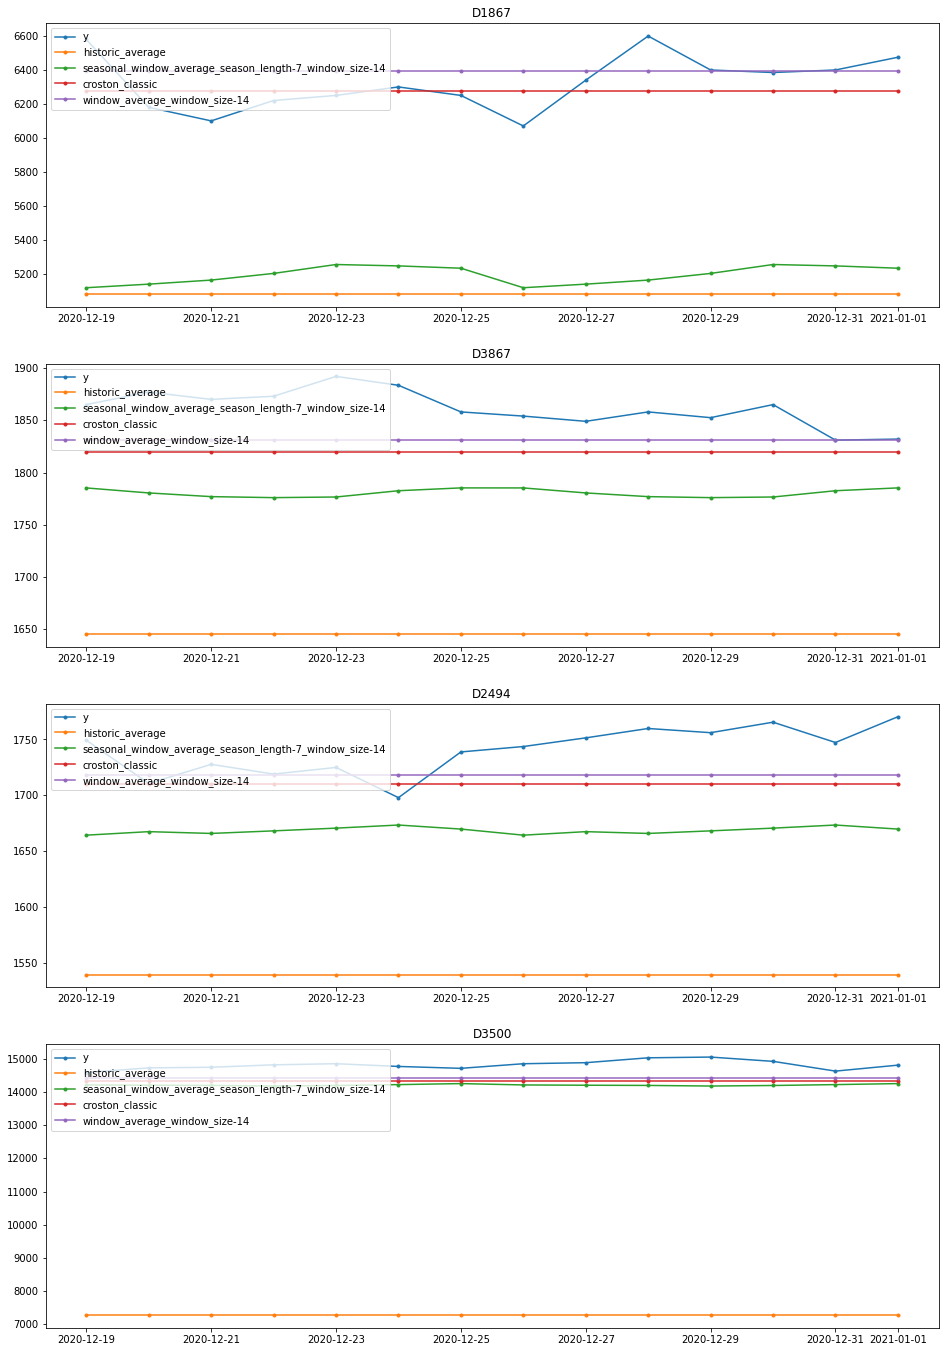

In [12]:
#%gist gistname: plot-forecasts-statsforecast.py
plot_models = random.sample(models, k=4)
plot_grid_prediction(forecasts[['unique_id', 'ds', 'y']], forecasts[['unique_id', 'ds'] + models], models=plot_models)

## Create your own model

Aditionally you can use the full power of `StatsForecast` to parallelize your own model. You just need to define a function with mandatory parameters `y`, the target time series, and `h`, the horizon to forecast; in addition you can add more optional parameters. The function's output must be a numpy array of size `h`. In the following example we'll fit a linear regression against time; this is a very basic model but it is useful to explain how to get the full potential of `statsforecast`.

In [13]:
#%gist gistname: lr-statsforecast.py
from sklearn.linear_model import LinearRegression

def linear_regression_time(y: np.ndarray, h: int) -> np.ndarray:
    X = np.arange(y.shape[0] + h).reshape(-1, 1) + 1
    X_train = X[:y.shape[0]]
    X_test = X[-h:]
    
    reg = LinearRegression().fit(X_train, y)
    
    return reg.predict(X_test)

In [14]:
#%gist gistname: lr-results-statsforecast.py upload: both
fcst = StatsForecast(df=series, models=[linear_regression_time], freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for linear_regression_time.


CPU times: user 371 ms, sys: 152 ms, total: 523 ms
Wall time: 1.02 s


,unique_id,ds,linear_regression_time
0,D1,2020-12-19,1960.663818
1,D1,2020-12-20,1961.733643
2,D1,2020-12-21,1962.803345
3,D1,2020-12-22,1963.873047
4,D1,2020-12-23,1964.942749
...,...,...,...
59173,D999,2020-12-28,1028.366333
59174,D999,2020-12-29,1028.374634
59175,D999,2020-12-30,1028.382935
59176,D999,2020-12-31,1028.391235


A more complicated example with extra parameters would be a Lasso regression as follows,

In [15]:
#%gist gistname: lasso-statsforecast.py
from sklearn.linear_model import Lasso

def lasso_regression_time(y: np.ndarray, h: int, alpha: float) -> np.ndarray:
    X = np.arange(y.shape[0] + h).reshape(-1, 1) + 1
    X_train = X[:y.shape[0]]
    X_test = X[-h:]
    
    reg = Lasso(alpha=alpha).fit(X_train, y)
    
    return reg.predict(X_test)

Instead of passing the model, you just need to pass a tuple with the function and the parameter you want to use,

In [16]:
#%gist gistname: lasso-results-statsforecast.py upload: both
fcst = StatsForecast(df=series, models=[(lasso_regression_time, 20)], freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for lasso_regression_time_alpha-20.


CPU times: user 348 ms, sys: 142 ms, total: 490 ms
Wall time: 947 ms


,unique_id,ds,lasso_regression_time_alpha-20
0,D1,2020-12-19,1960.544434
1,D1,2020-12-20,1961.614014
2,D1,2020-12-21,1962.683472
3,D1,2020-12-22,1963.752930
4,D1,2020-12-23,1964.822388
...,...,...,...
59173,D999,2020-12-28,1028.250122
59174,D999,2020-12-29,1028.258301
59175,D999,2020-12-30,1028.266357
59176,D999,2020-12-31,1028.274536


Finally, you can train both models and a `historic_average` model (for benchmarking purposes) at the same time defining the models list as follows,

In [17]:
#%gist gistname: lr-lasso-statsforecast.py upload: both
models = [historic_average, linear_regression_time, (lasso_regression_time, 20)]

fcst = StatsForecast(df=series, models=models, freq='D', n_jobs=cpu_count())
%time forecasts = fcst.forecast(horizon)
forecasts.reset_index()

INFO:statsforecast.core:Computing forecasts
INFO:statsforecast.core:Computed forecasts for historic_average.
INFO:statsforecast.core:Computed forecasts for linear_regression_time.
INFO:statsforecast.core:Computed forecasts for lasso_regression_time_alpha-20.


CPU times: user 403 ms, sys: 155 ms, total: 558 ms
Wall time: 2.9 s


,unique_id,ds,historic_average,linear_regression_time,lasso_regression_time_alpha-20
0,D1,2020-12-19,1422.054199,1960.663818,1960.544434
1,D1,2020-12-20,1422.054199,1961.733643,1961.614014
2,D1,2020-12-21,1422.054199,1962.803345,1962.683472
3,D1,2020-12-22,1422.054199,1963.873047,1963.752930
4,D1,2020-12-23,1422.054199,1964.942749,1964.822388
...,...,...,...,...,...
59173,D999,2020-12-28,1023.906494,1028.366333,1028.250122
59174,D999,2020-12-29,1023.906494,1028.374634,1028.258301
59175,D999,2020-12-30,1023.906494,1028.382935,1028.266357
59176,D999,2020-12-31,1023.906494,1028.391235,1028.274536


Now we can calculate the FVA for the linear and lasso regression based on the historic average model.

In [18]:
#%gist gistname: own-models-test-set-statsforecast.py
forecasts = forecasts.reset_index().merge(series_test, how='left', on=['unique_id', 'ds'])
models = forecasts.drop(columns=['unique_id', 'ds', 'y']).columns.to_list()

In [19]:
#%gist gistname: own-models-fva-statsforecast.py upload: both
y = forecasts['y'].values
mape_bench = mape(y, forecasts['historic_average'].values)

fva = {}
for model in models:
    mape_model = mape(y, forecasts[model].values)
    fva[model] = mape_bench - mape_model
    
pd.DataFrame(fva, index=['FVA']).T.sort_values('FVA').rename_axis('model').reset_index()

,model,FVA
0,historic_average,0.000000
1,linear_regression_time,4.780768
2,lasso_regression_time_alpha-20,4.782328


So, the table shows a positive FVA for both models; we can also see that the regularization provided by the Ridge regression improves the FVA.

## Conclusion

In this post, we introduce statsforecast, a library written in python to quickly fit statistical models. As we saw, in the practice of time series forecasting it is very useful to first fit a simple model, as a benchmark. This benchmark model allows to build more complex models and also to show that its complexity brings value to the process through the FVA.
Statsforecast allows you to create benchmark models in a simple way; moreover, it allows you to fit your own models efficiently by fitting in parallel.

## WIP and Next steps

**statsforecast** is a work in progress. In next releases we plan to include:
- Automated backtesting.
- Ensembles (such as [fforma](https://github.com/FedericoGarza/fforma)).
- More statistical models with exogenous variables.

If you're interested you can learn more in the following resources:
* GitHub repo: https://github.com/Nixtla/statsforecast
* Documentation: https://nixtla.github.io/statsforecast/